In [1]:
''' Load dependencies '''

### Elementary libraries
import pandas as pd
import numpy as np
from numpy import linalg 

### Graphic libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import seaborn as sns


### Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

### Some Scikit-learn utils
from sklearn.cluster import BisectingKMeans, KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


### Models
from xgboost import XGBClassifier, plot_importance
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet



### Some cosmetics and makeup add-ons
import warnings
# prevents numpy and pandas scientific/exponential notation on print, default is False
# force-suppressing the scientific notation, it is rounded and justified
#np.set_printoptions(suppress=True, formatter={'float_kind': '{:0.4f}'.format})
pd.options.display.float_format = '{:.4f}'.format
# ignoring warnings, suppressing/preventing/hushing up all warnings
warnings.filterwarnings(action='ignore')
sns.set_style("whitegrid")

colors = ['blue', 'orange', 'green', 'red']
pal = sns.color_palette(colors, 4)


In [2]:

''' 
 
this is an user-defined function: creating our own functions based on our requirements especially to reduce the coding
  
*args in Python (Non-Keyword Arguments): arbitrary keyword argument, *args can pass a variable number of arguments     
**kwargs in Python (Keyword Arguments): arbitrary keyword argument, **kargs can pass a variable number of arguments 
 
'''

def take_desired_interval(data: pd.DataFrame, start_date: pd.to_datetime, end_date: pd.to_datetime) -> pd.DataFrame:
    
    #print(f'\n')
    """ Filtered set of data based on the given period and performing custom feature scaling as well: """

    # body of the function
    df = pd.pivot_table( data.loc[(data['DateTime'] >= start_date) & (data['DateTime'] <= end_date)],
                         values='Amount',            # ['A', 'B']      
                         index='Client', 
                         columns='Top Category', 
                         aggfunc={'Amount': 'sum'},  # {'A':'sum', 'B':'mean'}
                         fill_value=0, 
                         margins=True, 
                         dropna=True, 
                         margins_name='total',  # All
                         observed=False, 
                         sort=True
                       )

    ''' 
    performing custom feature scaling
    '''

    for row in df.itertuples():
        df.at[row.Index, 'money'] = df.loc[row.Index, 'money'] / (df.loc[row.Index, 'total'])
        df.at[row.Index, 'self_realization'] = df.loc[row.Index, 'self_realization'] / (df.loc[row.Index, 'total'])
        df.at[row.Index, 'socialization'] = df.loc[row.Index, 'socialization'] / (df.loc[row.Index, 'total'])
        df.at[row.Index, 'survival'] = df.loc[row.Index, 'survival'] / (df.loc[row.Index, 'total'])


    ''' it means all rows except last one and all columns except the last column '''
    df = df.iloc[:-1, :-1]                

    return df

In [3]:
''' 
reading whole dataset from the given file and loading those data and save them in a DataFrame, named df_data

'''
working_df = pd.read_csv("/Users/USER/Desktop/2025 ITMO THESIS/Cleaned_data.csv", parse_dates=['DateTime'])  



## **3. Calculating between March 2019 - March 2020 and March 2021 - March 2022** 

## 3.1 Calculating the amount difference between March 2019 and March 2020

In [4]:
wdf_032019_pivoted = take_desired_interval(working_df, '2019-03-01', '2019-03-31')

wdf_032020_pivoted = take_desired_interval(working_df, '2020-03-01', '2020-03-31')

wdf_032020_032019 = wdf_032020_pivoted.sub(wdf_032019_pivoted, axis='columns', level = None, fill_value = 0) 

wdf_032020_032019

Top Category,money,self_realization,socialization,survival
Client,,,,
224,0.0000,0.0000,-0.1861,0.1861
1108,-0.3020,-0.0509,0.0000,0.3529
1117,-0.0085,-0.1073,-0.0176,0.1334
1197,-0.7626,0.0840,0.1244,0.5542
1223,0.1555,0.0000,-0.0310,-0.1245
...,...,...,...,...
3560436,-0.1629,0.2282,0.0591,-0.1243
3561841,0.3797,0.0699,0.0250,-0.4746
3561945,-0.3432,0.0998,-0.0616,0.3049


## 3.2 Calculating the amount difference between March 2022 and March 2021

In [5]:
wdf_032021_pivoted = take_desired_interval(working_df, '2021-02-24', '2021-03-26')

wdf_032022_pivoted = take_desired_interval(working_df, '2022-02-24', '2022-03-26')

wdf_032022_032021 = wdf_032022_pivoted.sub(wdf_032021_pivoted, axis='columns', level = None, fill_value = 0) 

wdf_032022_032021

Top Category,money,self_realization,socialization,survival
Client,,,,
224,0.0000,-0.0836,-0.2928,0.3764
1108,-0.6039,0.1850,0.0000,0.4189
1117,-0.1373,-0.1057,-0.0768,0.3198
1197,0.0000,-0.7766,-0.0448,0.8215
1223,-0.5985,0.0262,0.0983,0.4740
...,...,...,...,...
3560436,-0.2461,0.1412,-0.0230,0.1279
3561841,0.0277,0.0690,0.1160,-0.2127
3561945,-0.1195,-0.0562,-0.0350,0.2108


In [6]:
''' finding unique clients in both dataframes '''

unique_clients = wdf_032020_032019.index.intersection(wdf_032022_032021.index)

wdf_032020_032019 = wdf_032020_032019[wdf_032020_032019.index.isin(unique_clients)]

wdf_032022_032021 = wdf_032022_032021[wdf_032022_032021.index.isin(unique_clients)]

## 3.2 Segmentation process

In [7]:

model_KMeans = KMeans(n_clusters = 4, init = 'k-means++', n_init = 100, max_iter = 300, tol = 0.0001, random_state = 40, copy_x = True, algorithm = 'elkan')

''' fitting the model to our dataset '''    
model_KMeans.fit(wdf_032020_032019[['survival', 'socialization', 'self_realization', 'money']])

''' assigning new column to the wdf_032020_032019 dataframe and inserting the labels_ (= already predicted values) '''  
wdf_032020_032019['clusters_2020_2019'] = model_KMeans.labels_


wdf_032020_032019

Top Category,money,self_realization,socialization,survival,clusters_2020_2019
Client,,,,,
224,0.0000,0.0000,-0.1861,0.1861,2
1108,-0.3020,-0.0509,0.0000,0.3529,2
1117,-0.0085,-0.1073,-0.0176,0.1334,2
1197,-0.7626,0.0840,0.1244,0.5542,0
1223,0.1555,0.0000,-0.0310,-0.1245,1
...,...,...,...,...,...
3560436,-0.1629,0.2282,0.0591,-0.1243,1
3561841,0.3797,0.0699,0.0250,-0.4746,3
3561945,-0.3432,0.0998,-0.0616,0.3049,2


In [8]:

''' pd.DataFrame creates index by default '''

temp_2020_2019 = pd.DataFrame(wdf_032020_032019['clusters_2020_2019'].value_counts())

''' removing index from the temp_2020_2019 dataframe and renaming the colunms then sorting the dataframe '''

temp_2020_2019 = temp_2020_2019.reset_index() 

temp_2020_2019.rename(columns = {'index':'clusters_2020_2019', 'clusters_2020_2019':'number of clients in each cluster'}, inplace = True)

temp_2020_2019 = temp_2020_2019.sort_values(by = 'clusters_2020_2019', ascending = True)

temp_2020_2019


,clusters_2020_2019,number of clients in each cluster
2,0,1473
0,1,4001
1,2,3124
3,3,1391


## **4. Calculating between March 2021 and March 2022**


## 4.1 Segmentation process



In [9]:
''' predicting after fitting has been done'''  
predicted_values = model_KMeans.predict(wdf_032022_032021[['survival', 'socialization', 'self_realization', 'money']])

''' assigning new column to the wdf_032022_032021 dataframe and inserting the predicted values''' 
wdf_032022_032021['clusters_2022_2021'] = predicted_values


wdf_032022_032021

Top Category,money,self_realization,socialization,survival,clusters_2022_2021
Client,,,,,
224,0.0000,-0.0836,-0.2928,0.3764,2
1108,-0.6039,0.1850,0.0000,0.4189,0
1117,-0.1373,-0.1057,-0.0768,0.3198,2
1197,0.0000,-0.7766,-0.0448,0.8215,2
1223,-0.5985,0.0262,0.0983,0.4740,0
...,...,...,...,...,...
3560436,-0.2461,0.1412,-0.0230,0.1279,2
3561841,0.0277,0.0690,0.1160,-0.2127,1
3561945,-0.1195,-0.0562,-0.0350,0.2108,2


In [10]:
''' pd.DataFrame creates index by default '''

temp_2022_2021 = pd.DataFrame(wdf_032022_032021['clusters_2022_2021'].value_counts())

''' removing index from the temp_2022_2021 dataframe and renaming the colunms then sorting the dataframe '''

temp_2022_2021 = temp_2022_2021.reset_index() 

temp_2022_2021.rename(columns = {'index':'clusters_2022_2021', 'clusters_2022_2021':'number of clients in each cluster'}, inplace = True)

temp_2022_2021 = temp_2022_2021.sort_values(by = 'clusters_2022_2021', ascending = True)

temp_2022_2021

,clusters_2022_2021,number of clients in each cluster
2,0,1957
0,1,3662
1,2,2986
3,3,1384


## **4.2 Assessment of the strategical behavior in 2022-2021 according to 2020-2019**  

In [11]:
''' 

merging/combining DataFrames based on the 'client' column

inner: use intersection of keys from both DataFrames, in our case key is 'Client' index
on: column or index level names to join on, these must be found in both DataFrames
returns: a DataFrame of the two merged objects

'''

wdf_merged_m1 = wdf_032022_032021.merge(wdf_032020_032019['clusters_2020_2019'], on='Client', how='inner')

wdf_merged_m1 = wdf_merged_m1[['clusters_2022_2021','clusters_2020_2019']]

wdf_merged_m1

,clusters_2022_2021,clusters_2020_2019
Client,,
224,2,2
1108,0,2
1117,2,2
1197,2,0
1223,0,1
...,...,...
3560436,2,1
3561841,1,3
3561945,2,2


In [12]:
'''
selecting clients who stayed unchanged/identical/same in their clusters, who did not change thier clusters

'''

wdf_kept_clients = wdf_merged_m1[wdf_merged_m1['clusters_2022_2021'] == wdf_merged_m1['clusters_2020_2019']]

wdf_kept_clients

,clusters_2022_2021,clusters_2020_2019
Client,,
224,2,2
1117,2,2
2005,3,3
2213,1,1
3427,0,0
...,...,...
3549144,1,1
3550334,2,2
3558664,2,2


In [13]:
'''
selecting clients who changed thier clusters

'''

wdf_changed_clients = wdf_merged_m1[wdf_merged_m1['clusters_2022_2021'] != wdf_merged_m1['clusters_2020_2019']]

wdf_changed_clients

,clusters_2022_2021,clusters_2020_2019
Client,,
1108,0,2
1197,2,0
1223,0,1
1555,2,3
2677,2,3
...,...,...
3559291,2,1
3560436,2,1
3561841,1,3


## **5. Prediction phase by using efficient low level implementations of standard linear algebra algorithm such as the Frobenius norm** 

* Firstly, we grab the main time series pattern, known output with the range of '2018-01-01' and '2022-06-01'

In [14]:
working_df_kept = working_df.merge(wdf_kept_clients['clusters_2020_2019'], on='Client', how='inner') 
cols = ['Amount'] 
Q1 = working_df_kept[cols].quantile(0.25)
Q3 = working_df_kept[cols].quantile(0.75)
IQR = Q3 - Q1
working_df_kept = working_df_kept[~((working_df_kept[cols] < (Q1 - 1.5 * IQR)) | (working_df_kept[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]


working_df_changed = working_df.merge(wdf_changed_clients['clusters_2022_2021'], on='Client', how='inner')  
Q1 = working_df_changed[cols].quantile(0.25)
Q3 = working_df_changed[cols].quantile(0.75)
IQR = Q3 - Q1
working_df_changed = working_df_changed[~((working_df_changed[cols] < (Q1 - 1.5 * IQR)) | (working_df_changed[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]


working_df_kept

,Unnamed: 0,Client,Card,Amount,MCC,Category,Top Category,DateTime,Amount_L10,clusters_2020_2019
0,0,390989,3048567,878.0000,5814,food,survival,2018-01-01,2.9435,1
1,362,390989,3048567,1520.0000,5812,food,survival,2018-01-01,3.1818,1
2,739,390989,3048567,1520.0000,4121,travel,socialization,2018-01-01,3.1818,1
3,947,390989,3048567,790.0000,5533,travel,socialization,2018-01-01,2.8976,1
4,2401,390989,3048567,2700.0000,5814,food,survival,2018-01-02,3.4314,1
...,...,...,...,...,...,...,...,...,...,...
2371468,17092319,3448497,5027965,1948.7900,7311,misc,socialization,2022-03-03,3.2898,0
2371469,17329684,3448497,5027965,715.0000,5814,food,survival,2022-03-20,2.8543,0
2371470,17638281,3448497,5027965,543.0000,5912,health,survival,2022-04-13,2.7348,0
2371471,17986534,3448497,5027965,653.0000,5200,nonfood,socialization,2022-05-09,2.8149,0


In [15]:
working_df_kept_pivoted = pd.pivot_table(   working_df_kept, 
                                            values='Amount',                              # ['A', 'B']       
                                            index=pd.Grouper(freq='D', key='DateTime'), 
                                            columns='clusters_2020_2019', 
                                            aggfunc={'Amount': 'sum'},                    # {'A':'sum', 'B':'mean'}
                                            fill_value=None, 
                                            margins=False, 
                                            dropna=True, 
                                            margins_name='All',                           # Total
                                            observed=False, 
                                            sort=True
                                            )

working_df_kept_pivoted.rename(columns = {0:'Cluster_0', 1:'Cluster_1', 2:'Cluster_2', 3:'Cluster_3'}, inplace = True)
working_df_kept_pivoted = working_df_kept_pivoted.rolling(30).mean() #expanding(5).mean()
working_df_kept_pivoted['All_Clusters_kept'] = working_df_kept_pivoted.sum(axis = 1) 


working_df_changed_pivoted = pd.pivot_table(   working_df_changed, 
                                            values='Amount',                              # ['A', 'B']       
                                            index=pd.Grouper(freq='D', key='DateTime'), 
                                            columns='clusters_2022_2021', 
                                            aggfunc={'Amount': 'sum'},                    # {'A':'sum', 'B':'mean'}
                                            fill_value=None, 
                                            margins=False, 
                                            dropna=True, 
                                            margins_name='All',                           # Total
                                            observed=False, 
                                            sort=True
                                            )

working_df_changed_pivoted.rename(columns = {0:'Cluster_0', 1:'Cluster_1', 2:'Cluster_2', 3:'Cluster_3'}, inplace = True)
working_df_changed_pivoted = working_df_changed_pivoted.rolling(30).mean() #expanding(5).mean()
working_df_changed_pivoted['All_Clusters_changed'] = working_df_changed_pivoted.sum(axis = 1) 

working_df_kept_pivoted

clusters_2020_2019,Cluster_0,Cluster_1,Cluster_2,Cluster_3,All_Clusters_kept
DateTime,,,,,
2018-01-01,NaN,NaN,NaN,NaN,0.0000
2018-01-02,NaN,NaN,NaN,NaN,0.0000
2018-01-03,NaN,NaN,NaN,NaN,0.0000
2018-01-04,NaN,NaN,NaN,NaN,0.0000
2018-01-05,NaN,NaN,NaN,NaN,0.0000
...,...,...,...,...,...
2022-08-11,171852.4400,916680.3120,617319.9770,124471.1357,1830323.8647
2022-08-12,172968.4590,917778.9300,616175.3607,124871.4953,1831794.2450
2022-08-13,169278.8493,896498.7073,598392.5493,120767.8310,1784937.9370


In [16]:
working_df_clusters_2022_kept = working_df_kept_pivoted.loc[(working_df_kept_pivoted.index >= '2022-02-24') & (working_df_kept_pivoted.index <= '2022-03-26')]
working_df_clusters_2020_kept = working_df_kept_pivoted.loc[(working_df_kept_pivoted.index >= '2020-03-01') & (working_df_kept_pivoted.index <= '2020-03-31')]

working_df_clusters_2022_changed = working_df_changed_pivoted.loc[(working_df_changed_pivoted.index >= '2022-02-24') & (working_df_changed_pivoted.index <= '2022-03-26')]
working_df_clusters_2020_changed = working_df_changed_pivoted.loc[(working_df_changed_pivoted.index >= '2020-03-01') & (working_df_changed_pivoted.index <= '2020-03-31')]

working_df_clusters_2022_kept = working_df_clusters_2022_kept.div(1e3)
working_df_clusters_2020_kept = working_df_clusters_2020_kept.div(1e3)

working_df_clusters_2022_changed = working_df_clusters_2022_changed.div(1e3)
working_df_clusters_2020_changed = working_df_clusters_2020_changed.div(1e3)

#len(working_df_clusters_2022_kept)
len(working_df_clusters_2020_kept)

31

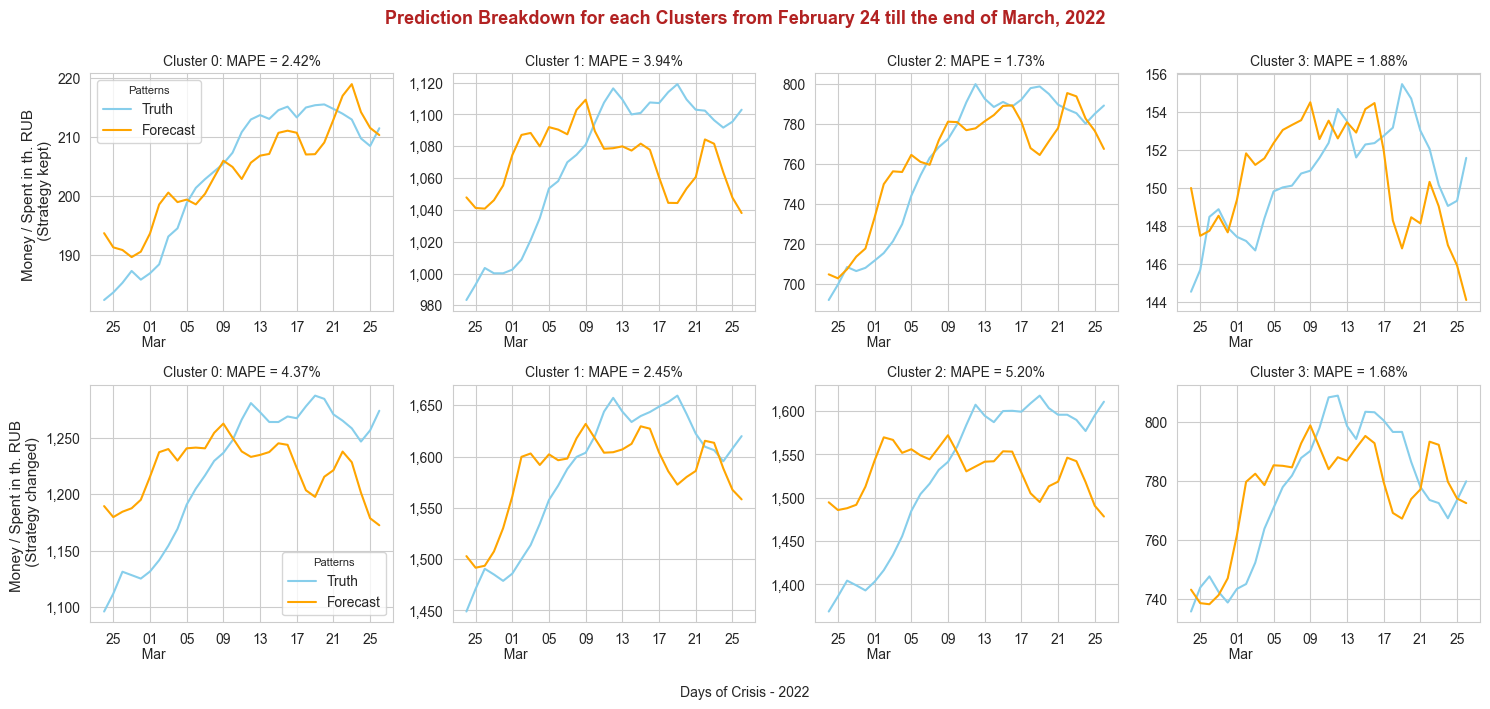

In [17]:
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (15, 7))
ax = ax.flat

for i in range(0, 8, 1):

    if i == 0:

        k = linalg.norm(working_df_clusters_2022_kept['Cluster_0'])/linalg.norm(working_df_clusters_2020_kept['Cluster_0'])
                                
        sns.lineplot(x=working_df_clusters_2022_kept.index, y = working_df_clusters_2022_kept['Cluster_0'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=working_df_clusters_2022_kept.index, y = k * working_df_clusters_2020_kept['Cluster_0'], ax=ax[i], color='orange', label='Forecast')       
        

        mape = mean_absolute_percentage_error(working_df_clusters_2022_kept.loc[:, 'Cluster_0'], (working_df_clusters_2020_kept.loc[:, 'Cluster_0'] * k)) * 100
        #R2_k = r2_score(working_df_clusters_2022_kept.iloc[:,0], working_df_clusters_2020_kept.iloc[:,0] * k)

        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        #sec.set_xlabel('Dates (2020)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='Patterns', loc='best') 
        ax[i].set_title(f'Cluster 0: MAPE = {mape:.2f}%', fontsize=10) # MAPE = {mape:.1f}%, R2 = {R2_k:.1f}%', fontsize=10)
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('Money / Spent in th. RUB \n (Strategy kept)', fontsize=11) 
        
   
    elif i == 1:


        k = linalg.norm(working_df_clusters_2022_kept['Cluster_1'].values)/linalg.norm(working_df_clusters_2020_kept['Cluster_1'].values)
                        
        sns.lineplot(x=working_df_clusters_2022_kept.index, y = working_df_clusters_2022_kept['Cluster_1'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=working_df_clusters_2022_kept.index, y = k * working_df_clusters_2020_kept['Cluster_1'], ax=ax[i], color='orange', label='Forecast') 

        mape = mean_absolute_percentage_error(working_df_clusters_2022_kept.iloc[:,1], working_df_clusters_2020_kept.iloc[:,1] * k) * 100


        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        #sec.set_xlabel('Dates (2020)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='Patterns', loc='best') 
        ax[i].set_title(f'Cluster 1: MAPE = {mape:.2f}%', fontsize=10) 
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].get_legend().remove()

    elif i == 2:

        k = linalg.norm(working_df_clusters_2022_kept['Cluster_2'].values)/linalg.norm(working_df_clusters_2020_kept['Cluster_2'].values)
                        
        sns.lineplot(x=working_df_clusters_2022_kept.index, y = working_df_clusters_2022_kept['Cluster_2'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=working_df_clusters_2022_kept.index, y = k * working_df_clusters_2020_kept['Cluster_2'], ax=ax[i], color='orange', label='Forecast') 

        mape = mean_absolute_percentage_error(working_df_clusters_2022_kept.iloc[:,2], working_df_clusters_2020_kept.iloc[:,2] * k) * 100


        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        #sec.set_xlabel('Dates (2020)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='Patterns', loc='best') 
        ax[i].set_title(f'Cluster 2: MAPE = {mape:.2f}%', fontsize=10)  
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].get_legend().remove()
 
    elif i == 3:

        k = linalg.norm(working_df_clusters_2022_kept['Cluster_3'].values)/linalg.norm(working_df_clusters_2020_kept['Cluster_3'].values)
                        
        sns.lineplot(x=working_df_clusters_2022_kept.index, y = working_df_clusters_2022_kept['Cluster_3'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=working_df_clusters_2022_kept.index, y = k * working_df_clusters_2020_kept['Cluster_3'], ax=ax[i], color='orange', label='Forecast') 

        mape = mean_absolute_percentage_error(working_df_clusters_2022_kept.iloc[:,3], working_df_clusters_2020_kept.iloc[:,3] * k) * 100


        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        #sec.set_xlabel('Dates (2020)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='Patterns', loc='best') 
        ax[i].set_title(f'Cluster 3: MAPE = {mape:.2f}%', fontsize=10)  
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].get_legend().remove()


        # ----------------------------------------------------------------------------------------------------------------------------------------------


    elif i == 4:

        k = linalg.norm(working_df_clusters_2022_changed['Cluster_0'])/linalg.norm(working_df_clusters_2020_changed['Cluster_0'])
                                
        sns.lineplot(x=working_df_clusters_2022_changed.index, y = working_df_clusters_2022_changed['Cluster_0'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=working_df_clusters_2022_changed.index, y = k * working_df_clusters_2020_changed['Cluster_0'], ax=ax[i], color='orange', label='Forecast')       
        

        mape = mean_absolute_percentage_error(working_df_clusters_2022_changed.iloc[:,0], working_df_clusters_2020_changed.iloc[:,0] * k) * 100


        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        #sec.set_xlabel('Dates (2020)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='Patterns', loc='best') 
        ax[i].set_title(f'Cluster 0: MAPE = {mape:.2f}%', fontsize=10) # MAPE = {mape:.1f}%, R2 = {R2_k:.1f}%', fontsize=10)
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('Money / Spent in th. RUB \n (Strategy changed)', fontsize=11) 
        
   
    elif i == 5:


        k = linalg.norm(working_df_clusters_2022_changed['Cluster_1'].values)/linalg.norm(working_df_clusters_2020_changed['Cluster_1'].values)
                        
        sns.lineplot(x=working_df_clusters_2022_changed.index, y = working_df_clusters_2022_changed['Cluster_1'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=working_df_clusters_2022_changed.index, y = k * working_df_clusters_2020_changed['Cluster_1'], ax=ax[i], color='orange', label='Forecast') 

        mape = mean_absolute_percentage_error(working_df_clusters_2022_changed.iloc[:,1], working_df_clusters_2020_changed.iloc[:,1] * k) * 100


        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        #sec.set_xlabel('Dates (2020)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='Patterns', loc='best') 
        ax[i].set_title(f'Cluster 1: MAPE = {mape:.2f}%', fontsize=10) 
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].get_legend().remove()

    elif i == 6:

        k = linalg.norm(working_df_clusters_2022_changed['Cluster_2'].values)/linalg.norm(working_df_clusters_2020_changed['Cluster_2'].values)
                        
        sns.lineplot(x=working_df_clusters_2022_changed.index, y = working_df_clusters_2022_changed['Cluster_2'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=working_df_clusters_2022_changed.index, y = k * working_df_clusters_2020_changed['Cluster_2'], ax=ax[i], color='orange', label='Forecast') 

        mape = mean_absolute_percentage_error(working_df_clusters_2022_changed.iloc[:,2], working_df_clusters_2020_changed.iloc[:,2] * k) * 100


        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        #sec.set_xlabel('Dates (2020)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='Patterns', loc='best') 
        ax[i].set_title(f'Cluster 2: MAPE = {mape:.2f}%', fontsize=10)  
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].get_legend().remove()
 
    else:

        k = linalg.norm(working_df_clusters_2022_changed['Cluster_3'].values)/linalg.norm(working_df_clusters_2020_changed['Cluster_3'].values)
                        
        sns.lineplot(x=working_df_clusters_2022_changed.index, y = working_df_clusters_2022_changed['Cluster_3'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=working_df_clusters_2022_changed.index, y = k * working_df_clusters_2020_changed['Cluster_3'], ax=ax[i], color='orange', label='Forecast') 

        mape = mean_absolute_percentage_error(working_df_clusters_2022_changed.iloc[:,3], working_df_clusters_2020_changed.iloc[:,3] * k) * 100


        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        #sec.set_xlabel('Dates (2020)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='Patterns', loc='best') 
        ax[i].set_title(f'Cluster 3: MAPE = {mape:.2f}%', fontsize=10)  
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].get_legend().remove()

                
fig.suptitle('Prediction Breakdown for each Clusters from February 24 till the end of March, 2022', fontsize = 13, fontweight = 'bold', color = 'firebrick', y = 0.995)
fig.supxlabel('Days of Crisis - 2022', fontsize = 10)
#plt.savefig('Cluster_Predictions_2020_norm.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

## **6. Prediction phase by using MaxS** 

In [18]:
temp = working_df_kept[((working_df_kept['DateTime'] >= '2018-01-01') & (working_df_kept['DateTime'] <= '2022-08-15'))].groupby(by = ['DateTime'], 
                                                                                                    axis=0, 
                                                                                                    level=None,
                                                                                                    as_index=True, 
                                                                                                    sort=True, 
                                                                                                    group_keys=True, 
                                                                                                    observed=False, 
                                                                                                    dropna=True)['Amount'].sum()

kept_clusters = temp.to_frame()
kept_clusters = kept_clusters.rolling(30).mean() #expanding(min_periods = 5).mean()
kept_clusters = kept_clusters.reset_index()
kept_clusters.index = pd.to_datetime(kept_clusters['DateTime'])
kept_clusters.drop('DateTime', axis=1, inplace=True)
wdf_kept_clusters = kept_clusters
kept_clusters = kept_clusters['Amount']


temp = working_df_changed[((working_df_changed['DateTime'] >= '2018-01-01') & (working_df_changed['DateTime'] <= '2022-08-15'))].groupby(by = ['DateTime'], 
                                                                                                    axis=0, 
                                                                                                    level=None,
                                                                                                    as_index=True, 
                                                                                                    sort=True, 
                                                                                                    group_keys=True, 
                                                                                                    observed=False, 
                                                                                                    dropna=True)['Amount'].sum()

changed_clusters = temp.to_frame()
changed_clusters = changed_clusters.rolling(30).mean() #expanding(min_periods = 5).mean()
changed_clusters = changed_clusters.reset_index()
changed_clusters.index = pd.to_datetime(changed_clusters['DateTime'])
changed_clusters.drop('DateTime', axis=1, inplace=True)
wdf_changed_clusters = changed_clusters
changed_clusters = changed_clusters['Amount']
#changed_clusters

''' prediction point, where the model will kick off to predict '''
prediction_point = pd.datetime(2022, 2, 24)    
M = 744
''' need to specify recent actual pattern just before prediction point '''
recent_actual_pattern_k =    kept_clusters.loc[pd.date_range(prediction_point - pd.Timedelta(M, unit='h'), prediction_point - pd.Timedelta(24, unit='h'), freq='d')] 
recent_actual_pattern_c = changed_clusters.loc[pd.date_range(prediction_point - pd.Timedelta(M, unit='h'), prediction_point - pd.Timedelta(24, unit='h'), freq='d')]
#recent_actual_pattern_k

most_similar_pattern_start_date_range_k = pd.datetime(2020, 3, 1) 
most_similar_pattern_end_date_range_k = pd.datetime(2020, 3, 31)

most_similar_pattern_start_date_range_c = pd.datetime(2020, 3, 1) 
most_similar_pattern_end_date_range_c = pd.datetime(2020, 3, 31)

most_similar_pattern_k = kept_clusters.loc[pd.date_range(most_similar_pattern_start_date_range_k, most_similar_pattern_end_date_range_k, freq='d')]
most_similar_pattern_c = changed_clusters.loc[pd.date_range(most_similar_pattern_start_date_range_c, most_similar_pattern_end_date_range_c, freq='d')]

#most_similar_pattern_k

model_k = LinearRegression()
x_train_k = np.column_stack((most_similar_pattern_k.values, np.ones(len(most_similar_pattern_k))))
model_k.fit(x_train_k, recent_actual_pattern_k.values)
most_similar_pattern_predicted_values_k = model_k.predict(x_train_k) 

model_c = LinearRegression()
x_train_c = np.column_stack((most_similar_pattern_c.values, np.ones(len(most_similar_pattern_c))))
model_c.fit(x_train_c, recent_actual_pattern_c.values)
most_similar_pattern_predicted_values_c = model_c.predict(x_train_c) 

''' now, we need to define the base pattern which is actually the time series piece which comes right after the most similar pattern on the time axis '''

base_pattern_range_k = pd.date_range(most_similar_pattern_k.index[-1] + pd.Timedelta(24, unit='h'), most_similar_pattern_k.index[-1] + pd.Timedelta(M, unit='h'), freq='d')
base_pattern_k = kept_clusters.loc[base_pattern_range_k]

base_pattern_range_c = pd.date_range(most_similar_pattern_c.index[-1] + pd.Timedelta(24, unit='h'), most_similar_pattern_c.index[-1] + pd.Timedelta(M, unit='h'), freq='d')
base_pattern_c = changed_clusters.loc[base_pattern_range_c]

#base_pattern_k

''' now, we need to define the base pattern which is actually the time series piece which comes right after the most similar pattern on the time axis '''

base_pattern_range_k = pd.date_range(most_similar_pattern_k.index[-1] + pd.Timedelta(24, unit='h'), most_similar_pattern_k.index[-1] + pd.Timedelta(M, unit='h'), freq='d')
base_pattern_k = kept_clusters.loc[base_pattern_range_k]

base_pattern_range_c = pd.date_range(most_similar_pattern_c.index[-1] + pd.Timedelta(24, unit='h'), most_similar_pattern_c.index[-1] + pd.Timedelta(M, unit='h'), freq='d')
base_pattern_c = changed_clusters.loc[base_pattern_range_c]

#base_pattern_k

prediction_range_k = pd.date_range(recent_actual_pattern_k.index[-1] + pd.Timedelta(24, unit='h'), recent_actual_pattern_k.index[-1] + pd.Timedelta(M, unit='h'), freq='d')
x_k = np.column_stack((base_pattern_k.values, np.ones(len(base_pattern_k))))

k = linalg.norm(recent_actual_pattern_k.values)/linalg.norm(most_similar_pattern_k.values)

y_k = model_k.predict(x_k * k) 
predicted_values_k = pd.DataFrame(y_k, index=prediction_range_k, columns=['Amount_k'])


prediction_range_c = pd.date_range(recent_actual_pattern_c.index[-1] + pd.Timedelta(24, unit='h'), recent_actual_pattern_c.index[-1] + pd.Timedelta(M, unit='h'), freq='d')
x_c = np.column_stack((base_pattern_c.values, np.ones(len(base_pattern_c))))

k = linalg.norm(recent_actual_pattern_c.values)/linalg.norm(most_similar_pattern_c.values)

y_c = model_c.predict(x_c * k)
predicted_values_c = pd.DataFrame(y_c, index=prediction_range_c, columns=['Amount_c'])


next_pattern_after_pp_k = kept_clusters.loc[prediction_range_k]
next_pattern_after_pp_c = changed_clusters.loc[prediction_range_c]

mape_k = mean_absolute_percentage_error(next_pattern_after_pp_k.values, predicted_values_k.values) * 100
mape_c = mean_absolute_percentage_error(next_pattern_after_pp_c.values, predicted_values_c.values) * 100

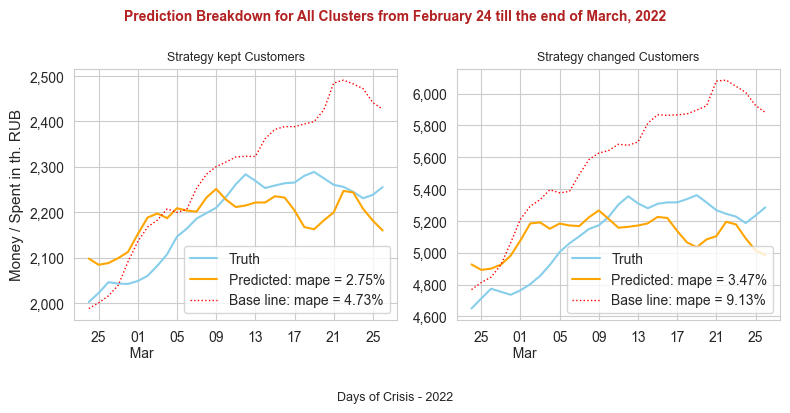

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))
ax = ax.flat

for i in range(0, 2, 1):

    if i == 0:

        k = linalg.norm(working_df_clusters_2022_kept['All_Clusters_kept'])/linalg.norm(working_df_clusters_2020_kept['All_Clusters_kept'])
        mape = mean_absolute_percentage_error(working_df_clusters_2022_kept.loc[:, 'All_Clusters_kept'], (working_df_clusters_2020_kept.loc[:, 'All_Clusters_kept'] * k)) * 100
                                        
        sns.lineplot(x=working_df_clusters_2022_kept.index, y = working_df_clusters_2022_kept['All_Clusters_kept'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=working_df_clusters_2022_kept.index, y = k * working_df_clusters_2020_kept['All_Clusters_kept'], ax=ax[i], color='orange', label='Predicted: mape = %.2f%%'%(mape))       
        sns.lineplot(x=predicted_values_k.index, y=predicted_values_k['Amount_k']/1e3, palette=pal, linewidth=1, ax = ax[i], color='red', ls=':', label='Base line: mape = %.2f%%'%(mape_k))
  
        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        #sec.set_xlabel('2022') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        #plt.setp(ax[i].get_legend().get_texts(), fontsize='10') 
        #plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='', loc='best') 
        ax[i].set_title('Strategy kept Customers', fontsize=9)
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('Money / Spent in th. RUB', fontsize=11) 
        
   
    else:

        k = linalg.norm(working_df_clusters_2022_changed['All_Clusters_changed'].values)/linalg.norm(working_df_clusters_2020_changed['All_Clusters_changed'].values)
        mape = mean_absolute_percentage_error(working_df_clusters_2022_changed.loc[:, 'All_Clusters_changed'], working_df_clusters_2020_changed.loc[:, 'All_Clusters_changed'] * k) * 100
                                
        sns.lineplot(x=working_df_clusters_2022_changed.index, y = working_df_clusters_2022_changed['All_Clusters_changed'], ax=ax[i], color='skyblue', label='Truth') 
        sns.lineplot(x=working_df_clusters_2022_changed.index, y = k * working_df_clusters_2020_changed['All_Clusters_changed'], ax=ax[i], color='orange', label='Predicted: mape = %.2f%%'%(mape)) 
        sns.lineplot(x=predicted_values_c.index, y=predicted_values_c['Amount_c']/1e3, palette=pal, linewidth=1, ax = ax[i], color='red', ls=':', label='Base line: mape = %.2f%%'%(mape_c))
      
        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        #sec.set_xlabel('2022') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='1') 
        #plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='', loc='best') 
        ax[i].set_title('Strategy changed Customers', fontsize=9) 
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
  

                
fig.suptitle('Prediction Breakdown for All Clusters from February 24 till the end of March, 2022', fontsize = 10, fontweight = 'bold', color = 'firebrick', y = 0.995)
fig.supxlabel('Days of Crisis - 2022', fontsize = 9)
#plt.savefig('Cluster_Predictions_2020_norm.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()